In [5]:
import csv
import pandas as pd

In [40]:
epochs = []
accuracies = []
losses = []

with open('./model_performance.csv', 'r') as f:
        reader = csv.reader(f)
        for r in reader:
            epochs.append(int(r[0]))
            accuracies.append(float(r[1]))
            losses.append(float(r[2]))
#             epochs[r[0]] = {
#                 "index": r[0],
#                 "accuracy": r[1],
#                 "avg-loss": r[2]
#             }

In [21]:
#df = pd.DataFrame.from_dict(epochs).T

In [22]:
import matplotlib.pyplot as plt

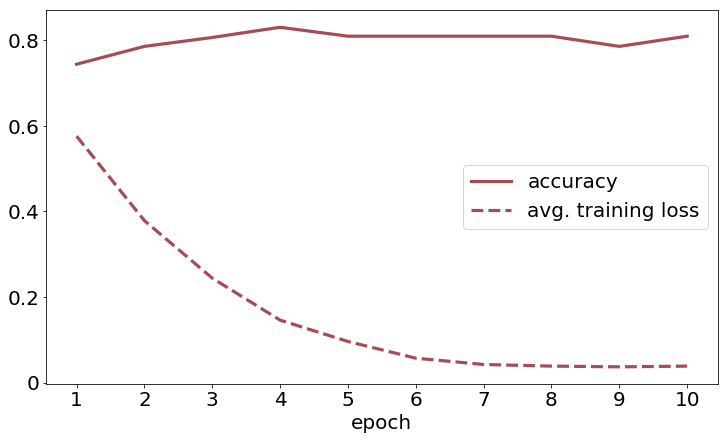

In [62]:
fig,ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

plt.plot(epochs, accuracies, color="#87111d", alpha=0.75, linewidth=3.2)
plt.plot(epochs, losses, color="#87111d", linestyle="--", alpha=0.75, linewidth=3.2)

ax.set_xticks(epochs)
ax.set_xlabel('epoch', fontsize=20)
    #ax.set_ylabel('frequency of similarity score values', fontsize=20)
ax.set_yticks([0,0.2,0.4,0.6,0.8])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8], fontsize=20)
ax.set_xticklabels(epochs, fontsize=20) 
ax.legend(["accuracy", "avg. training loss"], loc=7, fontsize=20)

plt.show()

# COMPUTE AVG WordCount over duplicate-free set

In [1]:
# initialize variables
import pandas as pd
import mysql.connector
import os
from dotenv import load_dotenv

load_dotenv(override=True)

# mysql credentials
PASSWORD = os.getenv("PASSWORD")
USER = os.getenv("USER")


load_dotenv(override=True)


True

In [2]:
# connect to db
import mysql.connector

mydb = mysql.connector.connect(
  host="127.0.0.1",
  user=USER,
  password=PASSWORD,
  database="mpp21"
)

mycursor = mydb.cursor()

In [3]:
import json

In [10]:
def select_word_count(curs, db):
    
    curs.execute("""SELECT article_id, metadata
                FROM articles 
                WHERE is_privacy = 'privacy'
                """)
                #LIMIT 200""") 
    
    arts = {}
    result = curs.fetchall()
    for r in result:
        arts[r[0]] = {
            "wordCount": json.loads(r[1])["wordCount"],
        }
    
    return arts

In [11]:
wcs = select_word_count(mycursor, mydb)

In [12]:
len(wcs)

26706

In [13]:
word_counts = []

for i in wcs.keys():
    word_counts.append(wcs[i]["wordCount"])

In [28]:
sorted(word_counts)[-10:]

[39527, 41559, 42882, 44387, 45358, 45635, 46316, 47781, 50730, 75608]

In [14]:
sum(word_counts) / len(word_counts)

979.9210991573879

In [17]:
import statistics
statistics.median(word_counts)

696.0

In [20]:
import csv

In [25]:
from collections import defaultdict

In [37]:
cosines = []

with open('./cosines_final/cosines_NYT_final.csv', 'r') as f:
        reader = csv.reader(f)
        for r in reader:
            cosines.append(round(float(r[0]), 2))


In [38]:
cos = defaultdict(lambda: 0)

In [39]:
for i in cosines:
    cos[i] += 1

In [40]:
cos

defaultdict(<function __main__.<lambda>()>,
            {0.71: 1,
             0.72: 1,
             0.74: 1,
             0.78: 1,
             0.81: 1,
             0.82: 4,
             0.83: 1,
             0.84: 2,
             0.87: 3,
             0.88: 2,
             0.89: 1,
             0.92: 1,
             0.93: 1,
             0.94: 2,
             0.96: 4,
             1.0: 38})

# TESTS

In [41]:
# modules
# import basics
import os
import re
import csv
import json
import time
# import requests
import numpy as np
import pandas as pd

from collections import defaultdict
import itertools as it

from time import sleep
from datetime import datetime, timedelta 
from dotenv import load_dotenv
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
#from requests.auth import HTTPBasicAuth

# text processing dependencies
# from bs4 import BeautifulSoup
# from boilerpy3 import extractors

# mysql dependencies
import mysql.connector

In [42]:
# db methods
def select_within_range(curs, db, n):
    
    curs.execute("SELECT article_id, title, date, metadata FROM articles WHERE newspaper = '" + n + "' AND date >= '" + timeframe_start + "' AND date <= '" + timeframe_end + "'") 
    
    arts = {}
    result = curs.fetchall()
    for r in result:
        arts[r[0]] = {
            "title": r[1],
            "date": r[2], 
            "wordCount": json.loads(r[3])["wordCount"]
        }
    
    return arts

In [43]:
weeks = []

timeframe_start = datetime.date(datetime(2010,12,27)) # monday
timeframe_end = datetime.date(datetime(2020,12,31))

dt = timeframe_start

while dt <= timeframe_end:
    
    weeks.append((dt, dt + timedelta(days=6))) # (start, end)
    dt += timedelta(days=7) # move to next week

In [44]:
timeframe_start = '2011-01-01'
timeframe_end = '2020-12-31'

In [45]:
def group_by_week(n):
    
    group = {}

    ctr = 1 # week

    for w in range(len(weeks)):
        group["week_" +str(w + 1) + ""] = []

    for week in weeks:
        for i in articles[n].keys():

            if articles[n][i]["date"] >= week[0] and articles[n][i]["date"] <= week[1]:
                dc = {"id": i,
                      "date": articles[n][i]["date"],
                      "title": articles[n][i]["title"]                    
                }
                group["week_" +str(ctr) + ""].append(dc)
        ctr += 1
        
    return group

In [51]:

def cos_sim(x, y):
    
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform([x, y])

    return cosine_similarity(sparse_matrix, sparse_matrix)[0] 
    # returns first row i.e. x vs y (second is y vs x)

In [89]:
def get_similarities_over_threshold(n):

    cosines = []
    tres_arts = []
    
    title_sims = []#defaultdict(lambda: [])

    for w in groups[n].keys(): # for each week
        pairs_in = []
        for a1 in groups[n][w]: # for articles within that week
            for a2 in groups[n][w]:
                try:
                    cs = cos_sim(a1["title"], a2["title"])
                    if round(cs[1], 2) >= 0.7: ####== 1.0:#>= 0.7:

                        if a1["id"] != a2["id"]:

                            if sorted((a1["id"], a2["id"])) not in pairs_in:
                
                                pairs_in.append(sorted((a1["id"], a2["id"])))
                                cosines.append(cs[1])
                                tres_arts.append((a1, a2, round(cs[1], 2)))
                                

                                title_sims.append([a1["id"], a2["id"]])

                except:
                    print("some error")
                    pass

    return cosines, tres_arts, title_sims

In [90]:
duplicates = {}
cosines = {}
articles_threshold = {}

In [91]:
def get_max_in_entry(e, n):
    
    dates = {}
    
    for i in e:
        dates[i] = articles[n][i]["date"]

    if len(set(dates.values())) > 1: # if they have the same date
        #print(dates)
        return max(dates, key=dates.get)
    
    else:
        word_counts = {}
        # second step (word count)
        for i in e: # each group
            word_counts[i] = articles[n][i]["wordCount"]
        return max(word_counts, key=word_counts.get)


def get_originals(l, n): # list
    
    originals = []
    
    for entry in l: # each group
        correct = get_max_in_entry(entry, n)
        
        originals.append(correct)
        

    return originals

def get_duplicates(l, o):
    
    ds = []
    
    for i in l:
        for j in i:
            if j not in o:
                ds.append(j)
    return ds

In [92]:
def verify_duplicate_correctness(a, b): # given the final lists of duplicates 
            # e.g. [a, b, c, d] where b, c, d are duplicates of a
    
    combinations = 0

    for i in a: # for each list
        combinations += len(list(it.combinations(i, 2))) # get all possible combinations of two
        
    print(combinations, len(b))
    return combinations == len(b)

In [93]:
def get_list_of_duplicates(tims):
    
    new_list = {}
    
    ## creates a dictionary of all articles that have a duplicate

    for i in tims: # for each pair that resulted in a similarity index above threshold
        for j in i: # take each element # the first element
            new_list[j] = [] # create a list of all its matches
            for l in tims: # go through the rest of the list
                if j in l: # find all its matches
                    [new_list[j].append(x) for x in l] # these are all the matches of
                                                        # article j, including j (so appending a pair)

    for i in new_list.keys(): # for all articles that have a duplicate
        new_list[i] = set(new_list[i]) # get each duplicate only once
        
    final_list = []

    for i in new_list.keys(): # for each article with a duplicate 
        if sorted(list((new_list[i]))) not in final_list: # only get final lists (i.e. remove counting the same groups twice)
                                        # what this essentially does is if you have [a, b] and [b, a]
                                        # where b is a duplicate for b and the other way around
                                        # we only count the pair once
            final_list.append(sorted(set(list((new_list[i]))))) # set
    
    return final_list

In [107]:
# get articles for newspaper n in range

n = "NZH"
articles = {}
articles[n] = {}


In [108]:
articles[n] = select_within_range(mycursor, mydb, n)

In [109]:
groups = {}
groups[n] = group_by_week(n)

In [110]:
#for n in newspapers.keys():
print(n)

cosines_threshold, threshold_articles, tsims = get_similarities_over_threshold(n)
cosines[n] = cosines_threshold
articles_threshold[n] = threshold_articles
fl = get_list_of_duplicates(tsims)
# for x in fl:
#     print(x)
valid = verify_duplicate_correctness(fl, threshold_articles)


originals = get_originals(fl, n)
duplicates[n] = get_duplicates(fl, originals)


print(len(duplicates[n]), "duplicates to be removed.")


NZH
some error
303 300
290 duplicates to be removed.


In [112]:
# for i in range(len(threshold_articles)):
#     if threshold_articles[i][2] != 1.0:
#         print(threshold_articles[i][0]["title"])
#         print(threshold_articles[i][1]["title"])
        
#         print()